**@BY 범상님**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import seaborn as sns



# Windows 유저
plt.rcParams['font.family'] = 'Malgun Gothic'

import missingno as msno

In [2]:
df_train = pd.read_csv('data/train.csv', encoding='utf-8')
df_test = pd.read_csv('data/test.csv', encoding='utf-8')

In [3]:
pd.crosstab(df_train['공급유형'], df_train['자격유형'] , margins = True).style.background_gradient(cmap = 'coolwarm')

자격유형,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,All
공급유형,,,,,,,,,,,,,,,,
공공분양,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7
공공임대(10년),205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,205
공공임대(50년),31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
공공임대(5년),3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
공공임대(분납),12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
국민임대,1539,21,0,0,34,0,9,155,0,0,0,0,0,0,0,1758
영구임대,2,0,95,0,3,3,0,0,49,0,0,0,0,0,0,152
임대상가,0,0,0,562,0,0,0,0,0,0,0,0,0,0,0,562
장기전세,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9


## 전처리
- 추가로해볼만한거
    - 오버샘플링
    - 결측치 처리 
        - a. Datawig Simple Imputer - 딥러닝을 통해 결측치 처리)
        - b. KNN Imputer를통한 결측치 채우기

### age_gender_info Data 병합
- 자동차 등록자료 통계 추가

In [4]:
def preprocess_merge(df):
    # 추가자료 - 2020년 12월 자동차 등록 통계자료
    car = pd.read_excel('data/자동차_등록자료_통계.xlsx', index_col='구분')
    car = car.iloc[:,:16]

    # dacon 제공자료 - 지역별 & 성별 & 연령별 인구 데이터
    age = pd.read_csv('data/age_gender_info.csv', encoding='utf-8',index_col = '지역')

    # 자동차 등록자료 통계에서 나오는 지역을 미리 sorting처리
    temp_lst = list(set(car.columns))
    temp_lst.sort()

    # age dataframe을 오름차순 정렬(강원도,경기도, 경상남도,...순) 하고, car dataframe과 동일 행,렬 간 곱셈처리
    np.score = np.array(age.sort_index()) * np.array(car.transpose().sort_index())

    df_score = pd.DataFrame(np.score)
    df_score['지역'] = temp_lst

    # 지역, 연령별 점수를 지역을 기준으로 전부 더해줌.
    df_score['지역점수'] = df_score.transpose().iloc[:22,:].sum().transpose()

    df_score = df_score[['지역', '지역점수']]

    df = pd.merge(df, df_score, how='left', on='지역')
    
    return df

### 공급유형, 자격유형 column 값 기준 묶어주기 및 결측치 처리

In [5]:
def preprocess1(df):
    df = df[~df['공급유형'].isna()]
    df.loc[df['공급유형'].isin(['공공임대(분납)','공공임대(5년)','공공임대(10년)','공공임대(50년)']),'공급유형'] = '공공임대'
    df = df[~df['자격유형'].isna()]
    df.loc[df['자격유형'].isin(['J', 'K', 'L', 'M', 'N', 'O']),'자격유형'] = 'JKLMNO'
    df['임대보증금'] = df['임대보증금'].replace('-',np.nan).astype(float)
    df['임대료'] = df['임대료'].replace('-',np.nan).astype(float)
    # df.loc[train['임대보증금']=='-','임대보증금'] = np.nan
    # df['임대보증금'] = df['임대보증금'].astype(float)
    
    return df

### Data 오류항목 2, 3 처리

In [6]:
def preprocess2(df):
#2번 error
    df = df[~df['단지코드'].isin(['C2085', 'C1397','C2431', 'C1649','C1036'])]
#3번 error
    df = df[~df['단지코드'].isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])]
    
    return df

### Data 오류항목 1 처리
- 총세대수 기준으로 부족분만큼 전용면적별세대수에 가중치 추가

In [7]:
def preprocess3(df) :
    df_temp = df[['단지코드','전용면적별세대수']].groupby(['단지코드'],as_index=False).sum()
    df_temp.columns = ['단지코드','총세대수(new)']
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    df['총세대수 차이'] = df['총세대수'] - df['총세대수(new)']
    df['전용면적별세대수'] = round(df['전용면적별세대수'] + (df['전용면적별세대수'] / df['총세대수(new)']) * df['총세대수 차이'], 3)
    
    # 공가수는 총세대수 기준으로 비율화. 공가수/총세대수
    df['공가수'] = df['공가수']/df['총세대수(new)']
    del df['총세대수(new)']
    del df['총세대수 차이']
    
    return df

### 임대보증금, 임대료, 면적 평균계산
- 총면적, Null값 처리

In [8]:
def preprocess4(df) :
    df['임대보증금'] = df['임대보증금'].replace('-',np.nan).astype('float')
    df['임대료'] = df['임대료'].replace('-',np.nan).astype('float')

    df['총면적'] = df['전용면적']*df['전용면적별세대수']
    df['총임대보증금'] = df['임대보증금']*df['전용면적별세대수']
    df['총임대료'] = df['임대료']*df['전용면적별세대수']
    
    df['임대료(YN)']=1
    df.loc[df['임대료'].isna(),'임대료(YN)']=0

    df['임대보증금(YN)']=1
    df.loc[df['임대보증금'].isna(),'임대료(YN)']=0
    
    del df['전용면적']
    
    return df

In [9]:
def preprocess5(df):

    df_temp = df[['단지코드','총세대수','전용면적별세대수','총면적']]
    df_temp = df_temp.groupby(by=['단지코드','총세대수'], sort=False, as_index=False).sum()
    df_temp['평균면적'] = df_temp['총면적'] / df_temp['총세대수']
    del df_temp['총세대수']
    del df_temp['전용면적별세대수']
    del df_temp['총면적']
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    
    df_temp = df.loc[df['임대료(YN)']==1,['단지코드','총세대수','전용면적별세대수','총임대료']]
    df_temp = df_temp.groupby(by = ['단지코드','총세대수'], sort=False, as_index=False).sum()
    df_temp['평균임대료'] = df_temp['총임대료'] / df_temp['총세대수']
    del df_temp['총세대수']
    del df_temp['전용면적별세대수']
    del df_temp['총임대료']
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    
    df_temp = df.loc[df['임대보증금(YN)']==1,['단지코드','총세대수','전용면적별세대수','총임대보증금']]
    df_temp = df_temp.groupby(by = ['단지코드','총세대수'], sort=False, as_index=False).sum()
    df_temp['평균임대보증금'] = df_temp['총임대보증금'] / df_temp['총세대수']
    del df_temp['총세대수']
    del df_temp['전용면적별세대수']
    del df_temp['총임대보증금']
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    
    
    
    
    del df['임대보증금(YN)']
    del df['임대료(YN)']
    del df['임대료']
    del df['임대보증금']
    del df['총면적']
    del df['총임대료']
    del df['총임대보증금']
#     del df['전용면적별세대수']
    
    # row에 해당되지 않는 경우는 전부 임대보증금과 임대료가 없는 상황이므로 null->0으로 정정
    df['평균임대보증금'] = df['평균임대보증금'].replace(np.nan,0).astype('float')
    df['평균임대료'] = df['평균임대료'].replace(np.nan,0).astype('float')
    
    # 지하철역 수 없는 경우 null값을 가지므로, fillna 0
    df['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
    
    df = df.drop_duplicates()
    
    return df




In [10]:
def preprocess(df):
    df = preprocess_merge(df)
    df = preprocess1(df)
    df = preprocess2(df)
    df = preprocess3(df)
    df = preprocess4(df)
    df = preprocess5(df)
    
    return df

In [11]:
df_train = pd.read_csv('data/train.csv', encoding='utf-8')
df_test = pd.read_csv('data/test.csv', encoding='utf-8')
train = preprocess(df_train)
test = preprocess(df_test)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

### 자격유형, 공급유형,임대건물구분 count수로 변경
- One hot Encoding
- 전용면적별 세대수 곱하기

#### One-hot Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
train[train['자격유형']=='J']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적별세대수,공가수,자격유형,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,지역점수,평균면적,평균임대료,평균임대보증금


In [14]:
temp_train = train[['임대건물구분','자격유형','공급유형']]
temp_train['구분'] = 'train'
temp_test = test[['임대건물구분','자격유형','공급유형']]
temp_test['구분'] = 'test'
temp_full = pd.concat([temp_train,temp_test])

encoder = OneHotEncoder(sparse=False)
encoder.fit(temp_full)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [15]:
df_onehot = pd.DataFrame(encoder.fit_transform(temp_full))
df_onehot.columns = encoder.get_feature_names(temp_full.columns)
df_onehot_test=df_onehot[df_onehot['구분_test']==1]
df_onehot_train=df_onehot[df_onehot['구분_train']==1]
df_onehot_train.reset_index(drop=True, inplace = True)
df_onehot_test.reset_index(drop=True, inplace = True)
del df_onehot_test['구분_test']
del df_onehot_test['구분_train']
del df_onehot_train['구분_test']
del df_onehot_train['구분_train']

In [16]:
train = pd.concat([train,df_onehot_train],axis=1)
test = pd.concat([test,df_onehot_test],axis=1)

In [17]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적별세대수', '공가수', '자격유형',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수',
       '등록차량수', '지역점수', '평균면적', '평균임대료', '평균임대보증금', '임대건물구분_상가', '임대건물구분_아파트',
       '자격유형_A', '자격유형_B', '자격유형_C', '자격유형_D', '자격유형_E', '자격유형_F', '자격유형_G',
       '자격유형_H', '자격유형_I', '자격유형_JKLMNO', '공급유형_공공분양', '공급유형_공공임대',
       '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가', '공급유형_장기전세', '공급유형_행복주택'],
      dtype='object')

#### 전용면적별 세대수 곱하기

In [18]:
train.loc[:,'임대건물구분_상가':] = train.loc[:,'임대건물구분_상가':].mul(train['전용면적별세대수'],axis=0)
test.loc[:,'임대건물구분_상가':] = test.loc[:,'임대건물구분_상가':].mul(test['전용면적별세대수'],axis=0)

In [19]:
# encoding 된 column 제거
del train['임대건물구분']
del train['공급유형']
del train['자격유형']
del train['전용면적별세대수']

del test['임대건물구분']
del test['공급유형']
del test['자격유형']
del test['전용면적별세대수']

### 단지코드별 Row merge

In [20]:
train_final = train.groupby(list(train.loc[:,:'평균임대보증금'].columns),as_index=False).sum()
test_final = test.groupby(list(test.loc[:,:'평균임대보증금'].columns),as_index=False).sum()

In [21]:
set(train_final.columns).difference(set(test_final.columns))

{'등록차량수'}

## Pipeline and Data save
- Pipeline One-hot encoding + Standard Scaler (전처리만 진행)
- Train, Test split (y_test가 없으므로, train data를 잘라서 진행)

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [23]:
list(test_final.columns)

['단지코드',
 '총세대수',
 '지역',
 '공가수',
 '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
 '도보 10분거리 내 버스정류장 수',
 '단지내주차면수',
 '지역점수',
 '평균면적',
 '평균임대료',
 '평균임대보증금',
 '임대건물구분_상가',
 '임대건물구분_아파트',
 '자격유형_A',
 '자격유형_B',
 '자격유형_C',
 '자격유형_D',
 '자격유형_E',
 '자격유형_F',
 '자격유형_G',
 '자격유형_H',
 '자격유형_I',
 '자격유형_JKLMNO',
 '공급유형_공공분양',
 '공급유형_공공임대',
 '공급유형_국민임대',
 '공급유형_영구임대',
 '공급유형_임대상가',
 '공급유형_장기전세',
 '공급유형_행복주택']

In [24]:
categorical_features = ['지역']
categorical_transformer = OneHotEncoder(categories='auto',sparse = False)

# train feature에는 '등록차량수' 즉, ydata가 속해있으므로 test feature 기준으로 준비
numeric_features = list(test_final.columns)
numeric_features.remove('지역')
numeric_features.remove('단지코드')
numeric_transformer = StandardScaler()

In [25]:
train_final2 = train_final.copy()
del train_final2['등록차량수']

In [26]:
# 전처리용 transformer 만들고, pipeline 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])


preprocessor_pipe.fit(train_final2)

C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['총세대수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', ...pe=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False), ['지역'])]))])

In [27]:
# feature_name 살리기
feature_names_arr = np.array(numeric_features)
feature_names_arr = np.append(feature_names_arr, preprocessor.named_transformers_['cat'].get_feature_names(categorical_features) )

# train, test data pipeline 통과
x_train = pd.DataFrame(preprocessor_pipe.transform(train_final)
                       , columns = feature_names_arr)
x_test = pd.DataFrame(preprocessor_pipe.transform(test_final)
                      , columns = feature_names_arr)

C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [28]:
x_train['단지코드'] = train_final['단지코드']
x_train['등록차량수'] = train_final['등록차량수']
x_test['단지코드'] = test_final['단지코드']
y_train = x_train[['단지코드','등록차량수']]
df_pycaret = x_train.copy()
del x_train['등록차량수']

In [29]:
x_train = x_train.set_index('단지코드')
y_train = y_train.set_index('단지코드')
x_test = x_test.set_index('단지코드')

In [5]:
### data save
# x_train.to_csv('data_new/x_train.csv',encoding='euc-kr')
# y_train.to_csv('data_new/y_train.csv',encoding='euc-kr')
# x_test.to_csv('data_new/x_test.csv',encoding='euc-kr')
# df_pycaret.to_csv('data_new/df_pycaret.csv',encoding = 'euc-kr')

# ### data load
# x_train = pd.read_csv('data_new/x_train.csv',encoding='euc-kr',index_col='단지코드')
# y_train = pd.read_csv('data_new/y_train.csv',encoding='euc-kr',index_col='단지코드')
# x_test = pd.read_csv('data_new/x_test.csv',encoding='euc-kr',index_col='단지코드')
# df_pycaret = pd.read_csv('data_new/df_pycaret.csv',encoding = 'euc-kr', index_col='단지코드')

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# y_test data가 없으므로, x_train, y_train에서 30%씩을 test data로 활용
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

## ML
- 일반적인 방법 진행
- Pycaret 사용해보기

- 추가로 해볼만한거
    - ensemble - Voting 진행해보기
    - Feature Selection, PCA

### 전통적 ML (Default Model)

In [ ]:
# !pip install catboost
# !pip install ngboost

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

from catboost import CatBoostRegressor

from ngboost import NGBRegressor

from sklearn.svm import SVR

In [34]:
# Linear Regression
line_reg = LinearRegression()
line_reg.fit(xx_train, yy_train)
print("LinearRegression_MAE:", round(mean_absolute_error(yy_test,line_reg.predict(xx_test) ), 4))
print("LinearRegression_MSE:", round(mean_squared_error(yy_test,line_reg.predict(xx_test) ), 4))

LinearRegression_MAE: 125.1766
LinearRegression_MSE: 39238.9859


In [35]:
# XG boost
XGB_reg = XGBRegressor(random_state=0)
XGB_reg.fit(xx_train, yy_train)
print("default_XGB_MAE:", round(mean_absolute_error(yy_test,XGB_reg.predict(xx_test) ), 4))
print("default_XGB_MSE:", round(mean_squared_error(yy_test,XGB_reg.predict(xx_test) ), 4))

default_XGB_MAE: 122.3131
default_XGB_MSE: 43703.7572


In [1]:
# # Cat boost 
# # reference : https://dailyheumsi.tistory.com/136
# CAT_reg = CatBoostRegressor(
#          loss_function='MAE',
#          random_state=0
#     )
# CAT_reg.fit(xx_train,yy_train)
# print("default_CAT_MAE:", round(mean_absolute_error(yy_test,CAT_reg.predict(xx_test) ), 4))
# print("default_CAT_MSE:", round(mean_squared_error(yy_test,CAT_reg.predict(xx_test) ), 4))

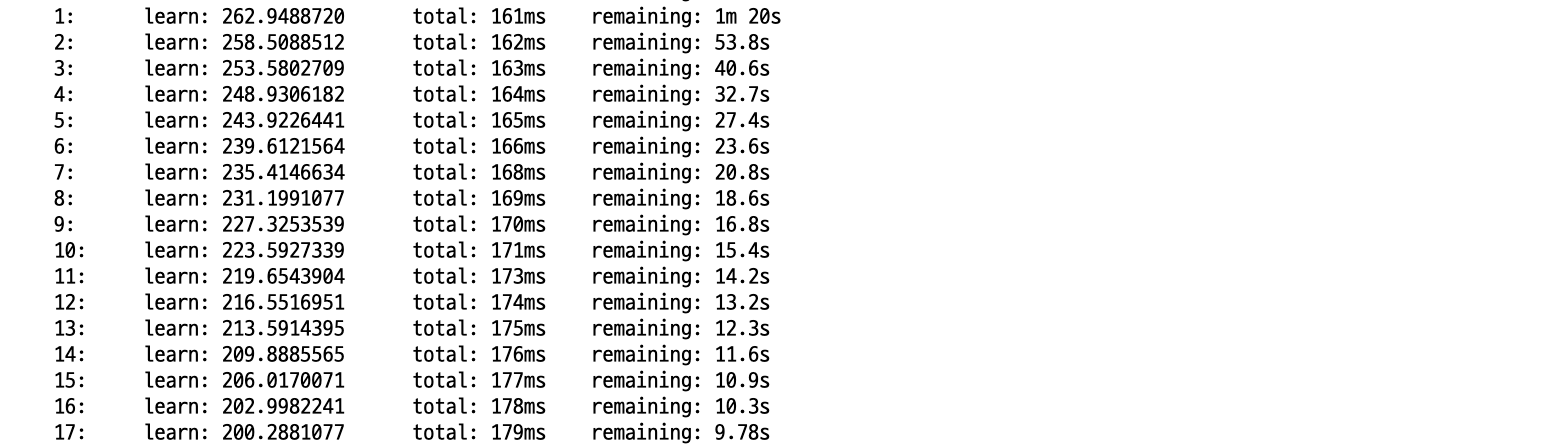

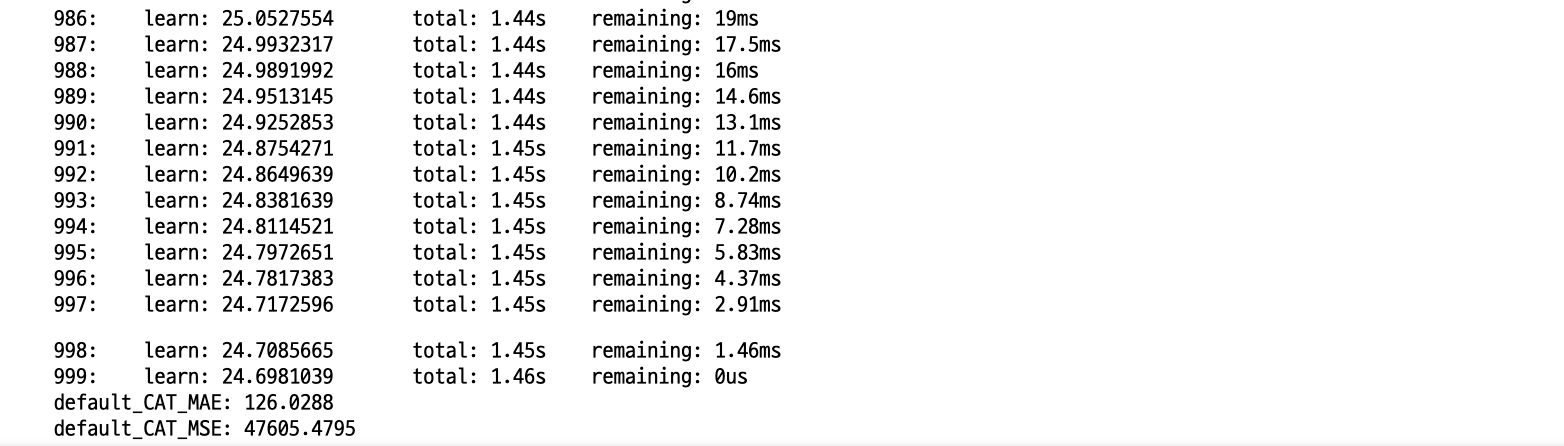

In [37]:
# NG boost
# https://github.com/stanfordmlgroup/ngboost <br>
# NG boost는 일반 ML과 다르게, 예측의 불확실성까지 예측함.
# - ex) 이 집의 가격은 5억일 확률이 75%다.

NGB_reg = NGBRegressor()
NGB_reg.fit(xx_train, yy_train)
print("default_NGB_MAE:", round(mean_absolute_error(yy_test,NGB_reg.predict(xx_test) ), 4))
print("default_NGB_MSE:", round(mean_squared_error(yy_test,NGB_reg.predict(xx_test) ), 4))

C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=7.3035 val_loss=0.0000 scale=1.0000 norm=276.5511
[iter 100] loss=6.5447 val_loss=0.0000 scale=2.0000 norm=240.6701
[iter 200] loss=6.0444 val_loss=0.0000 scale=1.0000 norm=82.8598
[iter 300] loss=5.7975 val_loss=0.0000 scale=1.0000 norm=71.5497
[iter 400] loss=5.6600 val_loss=0.0000 scale=1.0000 norm=65.1337
default_NGB_MAE: 126.0587
default_NGB_MSE: 47788.1494


In [38]:
# SVM
SVM_reg = SVR()
SVM_reg.fit(xx_train, yy_train)
print("MAE:", round(mean_absolute_error(yy_test,SVM_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,SVM_reg.predict(xx_test) ), 4))

MAE: 305.5255
MSE: 196405.356


C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 전통적 ML (AutoML with Hyperopt (CATboost, XGboost, NGboost))
https://teddylee777.github.io/thoughts/hyper-opt <br>
http://hyperopt.github.io/hyperopt/ <br>


#### setting

In [39]:
from sklearn.externals import joblib

# !pip install hyperopt
# 0.2.5 ver
from hyperopt import fmin, tpe, hp, anneal, Trials

from sklearn.model_selection import KFold, cross_val_score

In [45]:
random_state = 0
kf = KFold(n_splits=10, random_state=0)

In [46]:
def gb_mae_cv_CAT(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}
    
    CAT_HPO = CatBoostRegressor(random_state=random_state,**params)
    CAT_score = -cross_val_score(CAT_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return CAT_score

def gb_mae_cv_XGB(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}

    XGB_HPO = XGBRegressor(random_state=random_state,**params)
    XGB_score = -cross_val_score(XGB_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return XGB_score

def gb_mae_cv_NGB(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}

    NGB_HPO = NGBRegressor(random_state=random_state,**params)
    NGB_score = -cross_val_score(NGB_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return NGB_score


In [47]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 10),
       'learning_rate': hp.loguniform('learning_rate', -5, 0) #q uniform이 아니라 loguniform을 쓰는건, 등비척도로 움직이기 위해서
      }
space_XGB={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
           'max_depth' : hp.quniform('max_depth', 1,20,1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0) #q uniform이 아니라 loguniform을 쓰는건, 등비척도로 움직이기 위해서
      }

trials_CAT = Trials()
trials_XGB = Trials()
trials_NGB = Trials()

#### CAT HPO

In [32]:

best_CAT=fmin(fn=gb_mae_cv_CAT, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
                              #Tree of Parzen Estimators (TPE) 
                              #http://hyperopt.github.io/hyperopt/
          max_evals=50, # maximum number of iterations
          trials=trials_CAT, # logging
          rstate=np.random.RandomState(0) # fixing random state for the reproducibility
         )

In [ ]:
CAT_best_reg = CatBoostRegressor(learning_rate = best_CAT['learning_rate']
                             ,n_estimators = int(best_CAT['n_estimators']))

CAT_fitted_model = CAT_best_reg.fit(xx_train, yy_train)

# 모델 저장
joblib.dump(CAT_fitted_model, 'CAT_fitted_model.pkl', compress =True)


print("=============================================================")
print("CAT_HPO_MAE:", round(mean_absolute_error(yy_test,CAT_best_reg.predict(xx_test) ), 4))
print("CAT_HPO_MSE:", round(mean_squared_error(yy_test,CAT_best_reg.predict(xx_test) ), 4))


In [ ]:
# Loss Function 도식화
tpe_results_CAT=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_CAT.trials])

tpe_results_CAT_df=pd.DataFrame(tpe_results_CAT,
                           columns=['score', 'learning_rate', 'n_estimators'])
tpe_results_CAT_df.plot(subplots=True,figsize=(10, 10))

#### XGB HPO

In [49]:
# XGB HPO
best_XGB=fmin(fn=gb_mae_cv_XGB,
          space=space_XGB, 
          algo=tpe.suggest,
          max_evals=50,
          trials=trials_XGB,
          rstate=np.random.RandomState(0)
         )

100%|████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.87trial/s, best loss: 129.82166750959576]


In [50]:
XGB_best_reg = XGBRegressor(learning_rate = best_XGB['learning_rate']
                            ,max_depth = int(best_XGB['max_depth'])
                             ,n_estimators = int(best_XGB['n_estimators']))

XGB_fitted_model = XGB_best_reg.fit(xx_train, yy_train)

joblib.dump(XGB_fitted_model, 'XGB_fitted_model.pkl', compress =True)

print("=============================================================")
print("XGB_HPO_MAE:", round(mean_absolute_error(yy_test,XGB_best_reg.predict(xx_test) ), 4))
print("XGB_HPO_MSE:", round(mean_squared_error(yy_test,XGB_best_reg.predict(xx_test) ), 4))

XGB_HPO_MAE: 131.9215
XGB_HPO_MSE: 46948.2216


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A038E87EF0>,
      dtype=object)

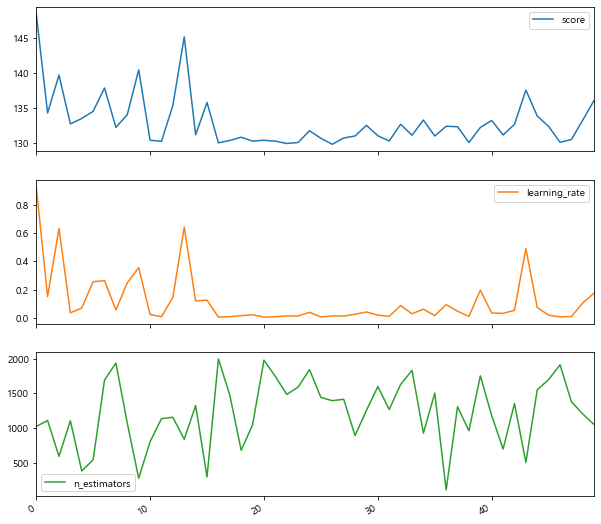

In [51]:
tpe_results_XGB=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_XGB.trials])

tpe_results_XGB_df=pd.DataFrame(tpe_results_XGB,
                           columns=['score', 'learning_rate', 'n_estimators'])
tpe_results_XGB_df.plot(subplots=True,figsize=(10, 10))

#### NGB HPO

In [ ]:
best_NGB=fmin(fn=gb_mae_cv_NGB,
          space=space, 
          algo=tpe.suggest,
          max_evals=50,
          trials=trials_NGB,
          rstate=np.random.RandomState(0)
         )

In [ ]:
NGB_best_reg = NGBRegressor(learning_rate = best_NGB['learning_rate']
                             ,n_estimators = int(best_NGB['n_estimators']))

NGB_fitted_model=NGB_best_reg.fit(xx_train, yy_train)

joblib.dump(NGB_fitted_model, 'NGB_fitted_model.pkl', compress =True)

print("=============================================================")
print("NGB_HPO_MAE:", round(mean_absolute_error(yy_test,NGB_best_reg.predict(xx_test) ), 4))
print("NGB_HPO_MSE:", round(mean_squared_error(yy_test,NGB_best_reg.predict(xx_test) ), 4))

In [ ]:
tpe_results_NGB=np.array([[
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_NGB.trials])

tpe_results_NGB_df=pd.DataFrame(tpe_results_NGB,
                           columns=[ 'learning_rate', 'n_estimators'])
tpe_results_NGB_df.plot(subplots=True,figsize=(10, 10))

### Feature Importance 도식화

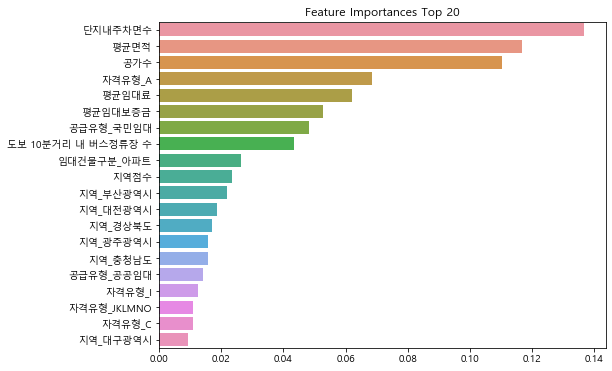

In [52]:
import seaborn as sns
# NGB regressor는 각 row별 값과 그에대한 확률이 리스트 형식으로 묶여있어 [0]에 있는 값을 추출해야함
# feature_importance_values = NGB_reg.feature_importances_[0] 
feature_importance_values = XGB_reg.feature_importances_

# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=xx_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top20 = feature_importances.sort_values(ascending=False)[1:21]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 20')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()

### Pycaret ( colab ) 
https://pbj0812.tistory.com/446

In [ ]:
# !pip install pycaret

In [42]:
import pycaret
from pycaret.classification import *
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
setup_reg = setup(data=df_pycaret, # df_train으로도 해보면 좋을듯
                  target='등록차량수' # 영어로 바꿔야될수도있음.
                  ) # setup으로 초기화 

In [ ]:
compare_models(exclude=['lr'], sort='Accuracy', n_select = 5, fold=5) 

### 제출파일

In [53]:
out = pd.DataFrame(XGB_reg.predict(x_test)
                   ,columns=['num']).set_index(x_test.index)
out.index.name='code'
out.to_csv('XGB.csv',encoding='euc-kr')

## Deep Learning
- 추가 필요 (전이학습 실습해보기)

### 기본 Modeling

In [54]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
import os
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# loss curve func
def plot_loss_curve(total_epoch=10, start=1):
    plt.figure(figsize=(15, 5))
    plt.plot(range(start, total_epoch +1), history.history['loss'][start-1:total_epoch], label='Train')
    plt.plot(range(start, total_epoch +1), history.history['val_loss'][start-1:total_epoch], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

In [ ]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=50, units=96, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.Activation('relu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

# dropout
model.add(layers.Dropout(rate=0.4)) 

model.add(layers.Dense(units=1, activation='linear'))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_absolute_error, # MAE / mean_absolute_error
              metrics=[metrics.mae])

In [ ]:
history = model.fit(xx_train, yy_train, batch_size=100, epochs=1000, validation_split=0.3, verbose=0)

In [ ]:
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MAE)')
plt.show()

In [ ]:
plot_loss_curve(total_epoch=1000, start=1)

In [ ]:
yy_pred = model.predict(xx_train)
model.evaluate(xx_test,yy_test)

### HPO with KerasTuner(in colab)

In [ ]:
# !pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
from tensorflow.keras import layers
from keras import initializers

import kerastuner as kt
import numpy as np
import IPython

In [ ]:
def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Dense(input_dim=xx_train.shape[1], units=64, activation=None, kernel_initializer=initializers.he_uniform()))
        

    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(1, activation=None))

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(),
                metrics = [keras.metrics.MeanAbsoluteError()])
    
    return model

In [ ]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_mean_absolute_error',
                                max_trials = 10,
                                directory = 'test_prac_dir',
                                project_name = 'Parking_lot')

In [ ]:
# best 3 model
tuner.search(xx_train, yy_train, epochs=10, validation_data = (xx_test, yy_test))
tuner.results_summary(num_trials=3)

In [ ]:
top3_models = tuner.get_best_hyperparameters(num_trials=3)

In [ ]:
for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx+1)
    print(model.values)
    print()

In [ ]:
best_hps = top3_models[0]

In [ ]:
print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

In [ ]:
models = tuner.get_best_models(num_models=3)
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(xx_test, yy_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

In [ ]:
for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

In [ ]:
# model saving
models[0].save('top_model_1')
models[0].save("top_model_1.h5")

In [ ]:
keras.models.load_model("top_model_1").evaluate(xx_test,yy_test)

In [ ]:
out = pd.DataFrame(top_model.predict(x_test),columns=['num']).set_index(x_test.index)
out.index.name='code'
out.to_csv('NN.csv',encoding='euc-kr')